In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models import Classifier, DeepSeaSNP, Conservation, SNPContext, MultiFeatures, EnhancerOneHot
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.preprocessing.label import LabelBinarizer

from cagi5_utils import get_breakpoint_df
from crossval import ChunkCV, df_cv_split, cvpreds_df_enhancer_folds
# from crossval import cvpreds_df_chunk_folds

## Load data

Read the training data with added conservation information.

In [2]:
df = pd.read_csv('data/cagi5_df.csv')
df.head()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.47,3.93,1.490
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,0.006,0.47,3.93,1.490
2,X,138612669,T,G,0.34,0.05,0,release_F9,0.006,0.47,3.93,1.490
3,X,138612670,A,C,0.00,0.00,0,release_F9,0.008,0.47,3.93,0.337
4,X,138612670,A,G,0.22,0.20,1,release_F9,0.008,0.47,3.93,0.337


TODO:
* setup some way of fixing the folds over which cv is done
* combine features from multiple layers with keras models
* try the gifford ensembl model

## Fit model

Fit a logistic regression model to the training data for each base element independently. Does this use a different cross-validation setup?

In [3]:
deepseadiffs = DeepSeaSNP(feattypes=['diff'])
cvdf_enh = cvpreds_df_enhancer_folds(df, Classifier, model_kwargs={'features': deepseadiffs,
                                                                   'classifier': 'lr'})
cvdf_enh.sample(6)

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS,cv_prediction,base_element
2209,10,51549172,T,C,0.03,0.03,0,release_MSMB,0.126,-0.377,2.59,-1.400,0.0,MSMB
837,11,5271271,G,C,0.16,0.01,0,release_HBG1,0.448,0.307,2.27,-0.476,1.0,HBG1
2196,10,51549168,G,A,0.01,0.01,0,release_MSMB,0.441,0.559,2.17,1.210,0.0,MSMB
666,11,5271054,T,C,0.12,0.03,0,release_HBG1,0.221,0.249,2.79,1.560,-1.0,HBG1
3739,1,109817730,T,C,0.00,0.00,0,release_SORT1,0.997,0.455,4.51,3.370,1.0,SORT1
899,20,42984336,G,A,0.10,0.24,1,release_HNF4A,0.539,0.651,5.16,5.160,1.0,HNF4A


Binarize the labels and calculate the AUC scores for all 2-way comparisons

In [4]:
binarizer = LabelBinarizer()
ybin = binarizer.fit_transform(cvdf_enh['class'])
print(roc_auc_score(ybin, binarizer.transform(cvdf_enh['cv_prediction']), average=None))

# lr diff: 0.6135, 0.542, 0.6000
# lr absdiff: 0.571, 0.587, 0.517
# gblinear diff: 0.612, 0.57, 0.58
print(binarizer.classes_)

binarizer = LabelBinarizer()
ybin = binarizer.fit_transform(cvdf_enh[cvdf_enh['base_element']=='F9']['class'])
print(roc_auc_score(ybin, binarizer.transform(cvdf_enh[cvdf_enh['base_element']=='F9']['cv_prediction']), average=None))

[0.61350038 0.54231944 0.60066257]
[-1  0  1]
[0.72258772 0.55522239 0.65946844]


## Create the cross-validation folds

Calculate the breakpoints inside each regulatory element.

In [5]:
breakpoint_df = get_breakpoint_df(df)
# Save breakpoints to CSV
breakpoint_df.to_csv('data/cagi5_bkpt.csv')
# Look at breakpoints
breakpoint_df[breakpoint_df['is_break']!='no'].head(15)

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS,cv_prediction,base_element,is_break,chunk_length,is_start,chunk_id
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.470,3.93,1.4900,-1.0,F9,start,NaN,True,0.0
47,X,138612684,G,T,-0.02,0.00,0,release_F9,0.048,-0.233,3.45,-2.0100,-1.0,F9,end,16.0,False,0.0
48,X,138612701,T,A,-0.36,0.37,-1,release_F9,0.009,0.470,3.27,1.9200,-1.0,F9,start,NaN,True,1.0
95,X,138612716,G,T,-0.15,0.04,0,release_F9,0.055,0.581,3.32,0.4310,-1.0,F9,end,16.0,False,1.0
96,X,138612765,C,A,0.07,0.01,0,release_F9,0.420,-0.304,4.22,0.2990,0.0,F9,start,NaN,True,2.0
143,X,138612780,T,G,0.18,0.02,0,release_F9,0.525,0.470,4.69,4.6900,1.0,F9,end,16.0,False,2.0
144,X,138612877,G,A,-0.09,0.05,0,release_F9,0.864,0.581,5.08,5.0800,1.0,F9,start,NaN,True,3.0
190,X,138612892,C,T,0.12,0.01,0,release_F9,0.508,0.581,5.08,1.7900,-1.0,F9,end,16.0,False,3.0
191,X,138612909,C,A,0.05,0.02,0,release_F9,0.453,0.581,5.08,0.0736,-1.0,F9,start,NaN,True,4.0
235,X,138612924,A,G,-0.01,0.00,0,release_F9,0.614,0.470,4.55,0.6710,-1.0,F9,end,16.0,False,4.0


## Cross-validation folds

Split the training data into folds respecting the breakpoints.

In [6]:
nfolds = 5
fold_dict = df_cv_split(breakpoint_df, nfolds)
fold_dict

{'release_F9': [[1], [2], [3], [0], [4]],
 'release_GP1BB': [[0, 1], [3], [5], [4], [2]],
 'release_HBB': [[1], [2], [0], [], []],
 'release_HBG1': [[2], [3], [1], [0], []],
 'release_HNF4A': [[1], [2], [3], [0], []],
 'release_IRF4': [[7, 1], [4, 6], [2, 5], [3], [0]],
 'release_IRF6': [[4, 5], [6, 8], [1, 2], [7, 0], [3]],
 'release_LDLR': [[4], [1], [3], [0], [2]],
 'release_MSMB': [[7, 2], [6, 3], [4, 1], [0, 5], [8]],
 'release_MYCrs6983267': [[5, 4], [2, 1], [8, 0], [7, 3], [6]],
 'release_PKLR': [[5, 0], [6, 2], [1, 4], [3], [7]],
 'release_SORT1': [[7, 5], [2, 8], [3, 0], [4, 6], [1]],
 'release_TERT-GBM': [[0], [2], [4], [3], [1]],
 'release_TERT-HEK293T': [[3], [2], [1], [4], [0]],
 'release_ZFAND3': [[6, 8, 0], [4, 2], [7, 5], [1, 10], [9, 3]]}

In [7]:
def make_roc_plot(cvdf_chunk):
    """Makes a ROC plot of significant effect prediction."""
    fpr, tpr, thresholds = roc_curve(cvdf_chunk['class'].abs(), cvdf_chunk['cv_prediction'],
                                     pos_label=1)
    fig = plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    return fig

Fit a logistic regression classifier to DeepSeaSNP features.

[-1  0  1]
[0.6192889  0.55296992 0.61458495]


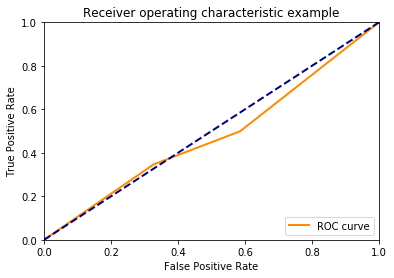

In [8]:
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': deepseadiffs, 'classifier': 'lr'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()
binarizer = LabelBinarizer()
ybin = binarizer.fit_transform(cvdf_chunk['class'])
print(binarizer.classes_)
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['cv_prediction']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

Note that by comparision with the cv setup above, the avg size of the training set is smaller

In [9]:
cvdf_chunk

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS,cv_prediction,base_element,is_break,chunk_length,is_start,chunk_id,is_train
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.470,3.93,1.4900,-1.0,F9,start,NaN,True,0,True
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,0.006,0.470,3.93,1.4900,-1.0,F9,no,NaN,False,0,True
2,X,138612669,T,G,0.34,0.05,0,release_F9,0.006,0.470,3.93,1.4900,-1.0,F9,no,NaN,False,0,True
3,X,138612670,A,C,0.00,0.00,0,release_F9,0.008,0.470,3.93,0.3370,-1.0,F9,no,NaN,False,0,True
4,X,138612670,A,G,0.22,0.20,1,release_F9,0.008,0.470,3.93,0.3370,-1.0,F9,no,NaN,False,0,True
5,X,138612670,A,T,0.12,0.03,0,release_F9,0.008,0.470,3.93,0.3370,-1.0,F9,no,NaN,False,0,True
6,X,138612671,T,A,0.06,0.02,0,release_F9,0.009,-0.404,3.93,-0.8070,1.0,F9,no,NaN,False,0,True
7,X,138612671,T,C,0.26,0.21,1,release_F9,0.009,-0.404,3.93,-0.8070,-1.0,F9,no,NaN,False,0,True
8,X,138612671,T,G,0.08,0.01,0,release_F9,0.009,-0.404,3.93,-0.8070,-1.0,F9,no,NaN,False,0,True
9,X,138612672,C,A,-0.13,0.05,0,release_F9,0.011,-0.251,3.93,0.6860,-1.0,F9,no,NaN,False,0,True


## XGBoost

In [10]:
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': deepseadiffs, 'classifier': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()
cvdf_chunk.sample(6)

/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS,cv_prediction,base_element,is_break,chunk_length,is_start,chunk_id,is_train
4197,6,37775287,C,A,-0.03,0.01,0,release_ZFAND3,0.001,-0.424,4.08,-4.990,0.0,ZFAND3,no,NaN,False,0,True
1415,6,396589,C,A,0.11,0.06,0,release_IRF4,0.064,0.076,0.00,0.000,1.0,IRF4,no,NaN,False,7,True
1445,1,209989208,G,A,0.43,0.66,1,release_IRF6,0.104,0.651,4.45,1.110,0.0,IRF6,no,NaN,False,0,True
3522,1,109817513,T,C,-0.45,1.00,-1,release_SORT1,0.959,0.455,3.77,2.640,-1.0,SORT1,no,NaN,False,4,True
2742,8,128413357,T,C,-0.04,0.02,0,release_MYCrs6983267,0.986,0.530,5.31,5.310,0.0,MYCrs6983267,no,NaN,False,4,True
366,22,19710943,A,G,-1.24,1.00,-1,release_GP1BB,0.005,-0.437,3.70,-0.164,0.0,GP1BB,no,NaN,False,2,False


[0.6679586  0.65216445 0.62261572]


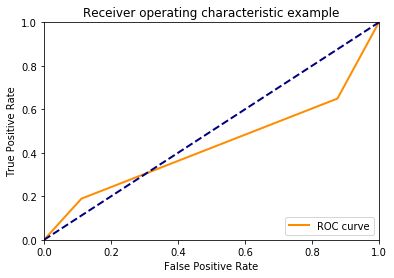

In [11]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['cv_prediction']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

## Enhancer one-hot

One hot encode the identity of the enhancer.

In [12]:
enhancer1hot = EnhancerOneHot()
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': enhancer1hot, 'classifier': 'lr'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

/home/john/Dev/cagimpra/models.py:221: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  enhancers = df['regulatory_element'].astype('category', categories=self.enh_names)


[0.51451902 0.63695984 0.53585677]


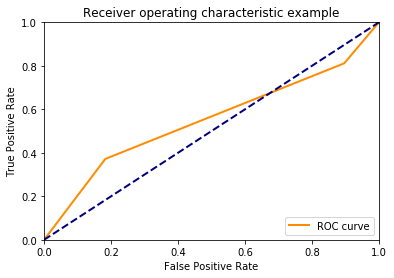

In [13]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['cv_prediction']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [14]:
deepE1h = MultiFeatures([deepseadiffs, enhancer1hot])
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': deepE1h, 'classifier': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

/home/john/Dev/cagimpra/models.py:221: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  enhancers = df['regulatory_element'].astype('category', categories=self.enh_names)
/home/john/Dev/cagimpra/models.py:221: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  enhancers = df['regulatory_element'].astype('category', categories=self.enh_names)
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/models.py:221: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  enhancers = df['regulatory_element'].astype('category', categories=self.enh_names)


[0.67033336 0.65969232 0.62537518]


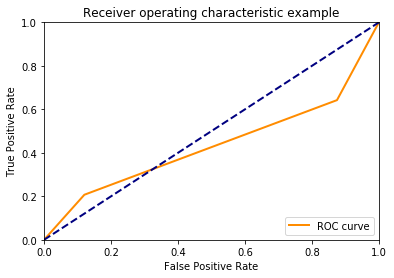

In [15]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['cv_prediction']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [16]:
snpcontext2 = SNPContext(context_size=2)
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': snpcontext2, 'classifier': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

[0.50258895 0.54286151 0.51057763]


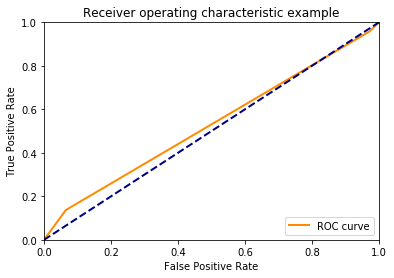

In [17]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['cv_prediction']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [18]:
snpcontext4 = SNPContext(context_size=4)
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': snpcontext4, 'classifier': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

[0.53177209 0.53912048 0.50993857]


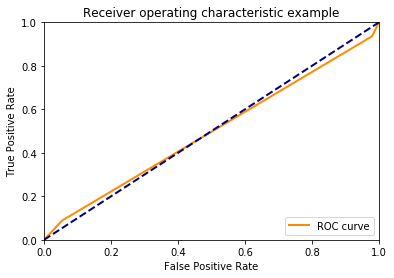

In [19]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['cv_prediction']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [20]:
conservation = Conservation()
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': conservation, 'classifier': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

[0.53051268 0.55980302 0.49877065]


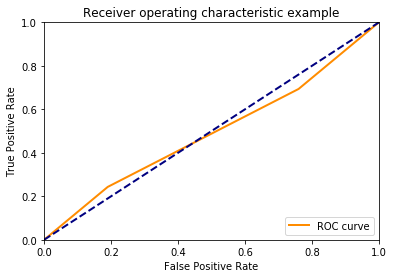

In [21]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['cv_prediction']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [23]:
features = MultiFeatures([conservation, snpcontext2, deepseadiffs])
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': features, 'classifier': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

[0.57959304 0.58817377 0.58654322]


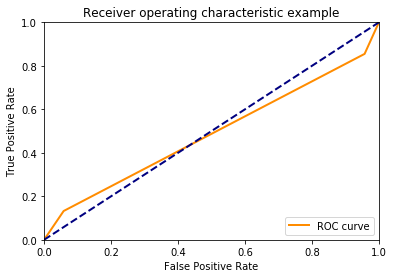

In [24]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['cv_prediction']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [25]:
features = MultiFeatures([conservation, deepseadiffs])
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': features, 'classifier': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

[0.67666237 0.65865399 0.61263775]


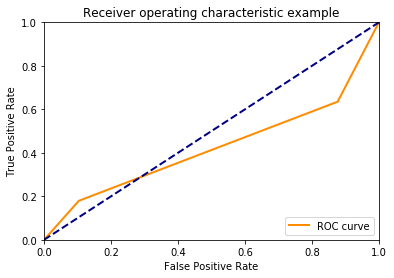

In [26]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['cv_prediction']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [ ]:
features = MultiFeatures([snpcontext2, deepseadiffs])
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': features, 'classifier': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [ ]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['cv_prediction']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [ ]:
binarizer = LabelBinarizer()
ybin = binarizer.fit_transform(cvdf_chunk[cvdf_chunk['regulatory_element']=='release_F9']['class'])
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk[cvdf_chunk['regulatory_element']=='release_F9']['cv_prediction']), average=None))

In [ ]:
cvdf_chunk[cvdf_chunk['cv_prediction'].isnull()]